<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/13_Multilayer_perceptrons/13_5_Activation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 13: Multi-layer Perceptrons 

# 13.5 Activation functions

In principle one can use any function as an activation for a multi-layer perceptron. For some time after their invention activations were chosen largely based on their biological plausibility, since this is the perspective in which neural networks themselves were largely regarded (as briefly detailed in Section 13.1.5). However these original biologically motivated activations presented serious technical challenges to properly optimizing models employing multi-layer perceptrons. Today activation functions are chosen based on practical considerations like our ability to properly optimize multi-layer perceptron models which employ them as well as (of course) the general performance they provide. In this Section we briefly review popular historical and modern activation functions. 

In [1]:
# install github clone - allows for easy cloning of subdirectories
!pip install github-clone
from pathlib import Path 

# clone images
if not Path('chapter_13_images').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/13_Multilayer_perceptrons/chapter_13_images
else:
    print('chapter_13_images already cloned!')
        

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from matplotlib import gridspec
import IPython, copy
from IPython.display import Image, HTML

# image paths
image_path_1 = "chapter_13_images/maxout.png"

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
chapter_13_images already cloned!


#### <span style="color:#a50e3e;">Example 1. </span>  The step and sigmoid activations

As broadly discussed in Section 13.1.5 the concept of neural networks was first introduced from a biological perspective where each unit of an architecture mimics a neuron in the human brain. Such neurons were thought to act somewhat like digital switches, being either completely 'on' or 'off' to transmitting information to connected cells. This belief naturally led to the use of a *step function* taking on just two values: $0$ (off) and $1$ (on). However this kind of step function (which we discuss in the context of logistic regression in Section 6.1) leads to piece-wise flat cost functions (like the one shown in Example 2 of Section 6.1) which are extremely difficult to optimize using any local optimization technique. In the context of logistic regression this sort of problem is what led to the *logistic sigmoid* introduced in Section 6.1.3. For the same reason the sigmoid function was one of the first popularly used activation functions. 

As a smooth approximation to the step function, the logistic sigmoid was viewed as a reasonable compromise between the desired neuronal model and the practical need to tune parameters properly. While the sigmoid performs very well in the comparatively simpler context of linear classification, when used as an activation function it often leads to a technical issue known as the *vanishing gradient* problem. 
If we examine the derivative of a single-input sigmoid, as shown in the bottom left panel of Figure below, we can see that any large (negative or positive) value passed through the derivative of the sigmoid is mapped to a value near zero. When used as activation in a multi-layer perceptron this potential problem can synergize across its presence in many units and layers, particularly when normalization schemes are not employed, and cause the gradient of a model employing such a network to *vanish* unexpectedly. This can prematurely halt the progress of first order optimizers, making it impossible to properly tune such networks.

The hyperbolic tangent or $\text{tanh}$ activation introduced in Section 6.2.2, being defined in terms of the logistic sigmoid, can similarly suffer from the vanishing gradient problem even though it typically performs considerably better in practice, perhaps because it centers its output about the origin.

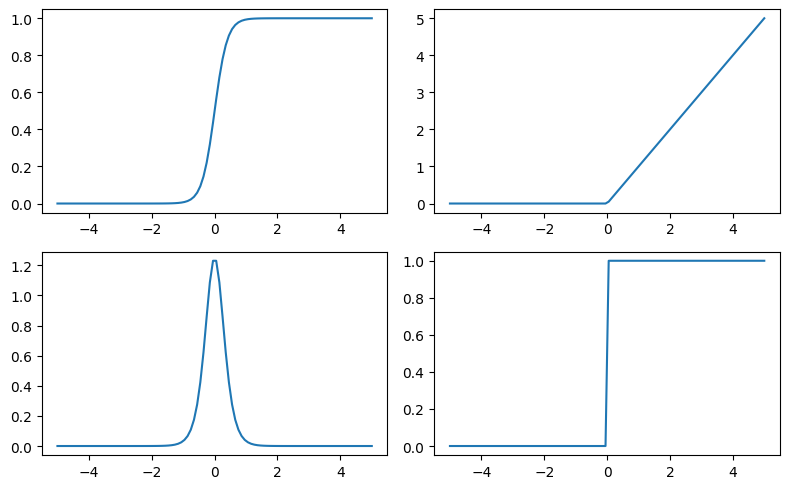

In [2]:
def activation1(w):
    a = 1/(1 + np.exp(-5*w))
    return a

def activation2(w):
    a = np.maximum(0,w)
    return a

# create input and functions to plot
w = np.linspace(-5,5,100)
a = activation1(w)
deg = 20
# a2 = my_act(w)
a2 = activation2(w)

# create derivatives to plot
der = grad(activation1)
b = np.array([der(v) for v in w])
der2 = grad(activation2)
b2 =  np.array([der2(v) for v in w])

### figure construction ###
# initialize figure
fig = plt.figure(figsize = (8,5))

# create subplot with 1 panel
gs = gridspec.GridSpec(2, 2) 
ax = plt.subplot(gs[0]); 
ax.plot(w,a);
ax = plt.subplot(gs[1]); 
ax.plot(w,a2);

ax = plt.subplot(gs[2]); 
ax.plot(w,b);
ax = plt.subplot(gs[3]); 
ax.plot(w,b2);

#### <span style="color:#a50e3e;">Example 2. </span>  The rectified linear unit (ReLU) activation

For decades after the multi-layer perceptron was first introduced researchers employed logistic activation functions almost exclusively. Only recently (the early 2010s, often the act of breaking away from tradition is a far greater feat than besting any test of mental strength) were alternative activation functions popularly entertained and tested, with the simple ReLU function providing (in many cases, largely in the context of image-based problems) far superior results than sigmoid activations.

A simpler function than a sigmoid (which involves both the use of a $\text{log}$ and exponential function), the ReLU function (and its relatives) have quickly become the most popular activation functions in use today. Notice, the ReLU function (plotted in the top right panel of Figure above) does not suffer from the same sort of vanishing gradient problem that the sigmoid does, as its derivative (plotted in the lower right panel of Figure above) only maps negative values to zero. However some care still must be taken when initializing and training a network employing ReLU activations. For example, akin to the need to initialize the ReLU cost function detailed in Section 6.3.1 away from the origin where the optimization process will stall, a multi-layer perceptron employing ReLU activations should be initialized away from the origin to avoid too many of the units (and their gradients) from vanishing.

#### <span style="color:#a50e3e;">Example 3. </span>  The maxout activation

The *maxout* activation, defined as

\begin{equation}
a(x) = \text{max}(v_0 + v_1x, \,w_0 + w_1x) \\
\end{equation}

is a relative of the ReLU that takes the maximum of two linear combinations of the input (instead of one linear combination and zero, as is the case with ReLU). Four instances of such a maxout unit are plotted below, in each instance its parameters are chosen at random. While this change seems algebraically rather minor, multi-layer perceptron architectures employing the maxout activation tend to have certain advantages over those employing $\text{tanh}$ and ReLU activations, including 1) fewer issues with problematic initialization (e.g., values close to or equal to zero for the *ReLU* activation are bad because the relu is minimized at zero), 2) fewer issues with gradients vanishing, and 3) empirically faster convergence with far fewer gradient descent steps. These advantages come with a simple price: the maxout activation has twice as many internal parameters as either the ReLU or $\text{tanh}$, hence architectures built with them have roughly twice as many parameters to tune.

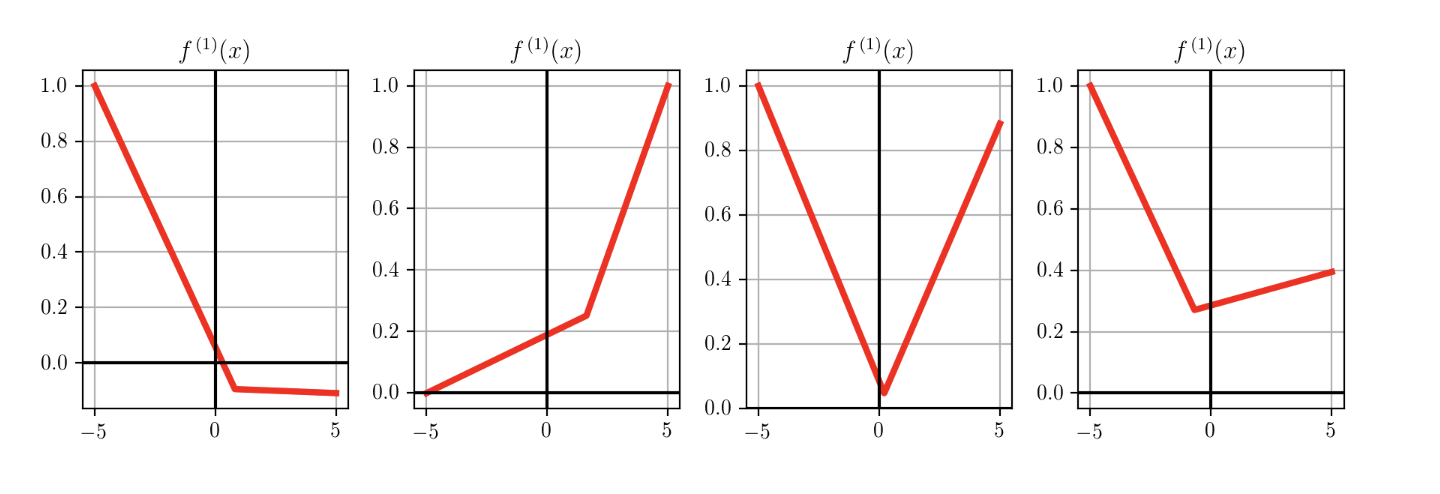

In [3]:
Image(image_path_1)

<figure>
</figure>

<a id='bib_cell'></a>

## References

[1]  W. S. McCulloch and W. Pitts. A logical calculus of the ideas immanent in nervous activity. The bulletin of mathematical biophysics, 5(4):115–133, 1943.

[2]  D. O. Hebb. The organization of behavior: a neuropsychological theory. John Wiley & Sons, New York, 1949.

[3]  F. Rosenblatt. The perceptron - a perceiving and recognizing automaton. Cornell Aeronautical Laboratory, 1957.

[4]  B. Merker. From probabilities to percepts: a subcortical "global best estimate buffer" as locus of phenomenal experience". In: S. Edelman, T. Fekete and N. Zach (Eds.) Being in time: Dynamical models of phenomenal experience. (pp. 37–79). John Benjamins Publishing Company, Amsterdam, 2012.